# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


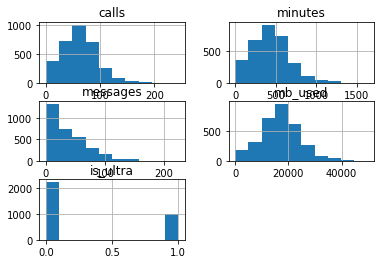

In [5]:
data.hist();

### Вывод

Никаких критичных замечаний не вижу. Есть количественные данные, которые можно привести к int, но на сколько знаю библиотеки работают с float и скорее всего сами обратно конвертируют к этому типу, либо откажутся работать. 

И ещё маленький нюанс - по последнему столбцу непонятно, что есть ещё тариф "Смарт", но это уже занудство. Хотя допускаю, что могут понадобиться для разных оценок, моделей, чтобы не запутаться - столбцы smart, ultra, is_smart.

У нас есть документация и мы условно принимаем, что по данным и типам всё хорошо, по тарифам и столбцам тоже. Ничего изменять и трогать не будем.

По гистограмме никаких отклонений или аномалий не увидел. Ящик с усами уже строить не стал.

## Разбейте данные на выборки

Отсечём сначала от датасета тестовую часть, и у нас останется та, с которой будем работать. Потом рабочую разобьём ещё на 2 части - тренировочную и валидационную. Посмотрим размеры, посчитаем, чтобы было соотношение 3:1:1

ОФФТОП: Я основную массу работы сделал, потом вспомнил о стратификации(подсмотрел в обсуждениях к проекту) и применил её. Будут иногда комментарии касательно этого. 

In [6]:
data_work, data_test = train_test_split(data, test_size=0.20, random_state=12345, stratify=data['is_ultra'])
data_train, data_valid = train_test_split(data_work, test_size=0.25, random_state=12345, stratify=data_work['is_ultra'])
print('Весь датасет', data.shape[0])
print('Размер тестовой выборки', data_test.shape[0])
print('Размер тренировочной выборки', data_train.shape[0])
print('Размер валидационной выборки', data_valid.shape[0])

Весь датасет 3214
Размер тестовой выборки 643
Размер тренировочной выборки 1928
Размер валидационной выборки 643


Сотношение 3:1:1 есть.

## Исследуйте модели

In [7]:
data_train.head()

,calls,minutes,messages,mb_used,is_ultra
1659,27.0,170.58,23.0,21798.61,0
2176,75.0,489.47,7.0,20478.94,1
108,47.0,300.12,123.0,31244.61,1
426,36.0,198.96,32.0,21596.86,0
1892,102.0,740.28,19.0,17864.12,0


Подготовим данные для дальнейшей работы с моделями.

In [8]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

### Решающее дерево

Первая модель для проверки - решающее дерево.

In [9]:
for depth in range(1,6):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid = model_tree.predict(features_valid)
    result_valid = accuracy_score(target_valid, predictions_valid)
    print(f'max_depth = {depth} : {result_valid}')

max_depth = 1 : 0.7589424572317263
max_depth = 2 : 0.7838258164852255
max_depth = 3 : 0.8040435458786936
max_depth = 4 : 0.8040435458786936
max_depth = 5 : 0.8164852255054432


Решающее дерево лучше всего себя показывает при максимальной глубине 5.

In [10]:
#model = DecisionTreeClassifier(random_state=12345, max_depth=3)
#model.fit(features_train, target_train)
#predictions_test = model.predict(features_test)
#result_test = accuracy_score(target_test, predictions_test)
#print('тест', result_test)

Оставлю гиперпараметры в диапазоне, который нашёл. Если честно то часы убил на это, десятки минут модели считались.
Критрей, автоподбор показал, gini, min samples и leaf он показал , что лучший по-умолчанию, которые используются - поэтому всё удалил.

In [11]:
parametrs_tree = {'max_depth': range(0, 11),
                 'max_leaf_nodes': range(0, 21)
                 }
clf_tree = DecisionTreeClassifier(random_state=12345)
grid_tree = GridSearchCV(clf_tree, parametrs_tree, cv=3)

grid_tree.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 286, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. De

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(0, 11),
                         'max_leaf_nodes': range(0, 21)})

In [12]:
grid_tree.best_params_

{'max_depth': 7, 'max_leaf_nodes': 11}

In [13]:
grid_tree.score(features_valid, target_valid)

0.7993779160186625

### Случайный лес

Тоже не удержался сделал тестовую сразу, мне пока интересно. Пока плохо понимаю почему так нельзя в рабочих проектах - только если, наверное, много моделей и мало времени.

Рассмотерл только один гиперпараметр - количество наблюдателей, деревьев.

ОФФТОП: понял почему так нельзя в рабочих проектах, с лесами получилось, что и на виладационной и тестовой самый лучший результат на одной модели. Посмотрел как прыгают значения в разную сторону на выборках.

In [14]:
best_result_random_forest = 0
for est in range(1, 11):
    model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_random_forest.fit(features_train, target_train)
    result_random_forest = model_random_forest.score(features_valid, target_valid)
    print('Валидационная,', 'количество деревьев', est, ':', result_random_forest)
    print('Тестовая', model_random_forest.score(features_test, target_test))
    if result_random_forest > best_result_random_forest:
        best_model_random_forest = model_random_forest
        best_result_random_forest = result_random_forest

print("Accuracy наилучшей модели на валидационной выборке:", best_result_random_forest, 'количество деревьев', est)

Валидационная, количество деревьев 1 : 0.7340590979782271
Тестовая 0.7340590979782271
Валидационная, количество деревьев 2 : 0.7713841368584758
Тестовая 0.7636080870917574
Валидационная, количество деревьев 3 : 0.7465007776049767
Тестовая 0.7589424572317263
Валидационная, количество деревьев 4 : 0.7884914463452566
Тестовая 0.7884914463452566
Валидационная, количество деревьев 5 : 0.7776049766718507
Тестовая 0.7744945567651633
Валидационная, количество деревьев 6 : 0.7962674961119751
Тестовая 0.7884914463452566
Валидационная, количество деревьев 7 : 0.7978227060653188
Тестовая 0.7807153965785381
Валидационная, количество деревьев 8 : 0.7962674961119751
Тестовая 0.7838258164852255
Валидационная, количество деревьев 9 : 0.8009331259720062
Тестовая 0.7838258164852255
Валидационная, количество деревьев 10 : 0.8133748055987559
Тестовая 0.80248833592535
Accuracy наилучшей модели на валидационной выборке: 0.8133748055987559 количество деревьев 10


Хотелось бы ещё добавить в случайный лес параметры деревья из прошлого пункта, но я незнаю сколько будет, у тебя, Исмаил считаться, поэтому оставлю вот так. 

Я всё равно пока плохо понимаю какие взаимосвязи и как залезть правильно под капот.

У меня побольше минуты, меньше трех

In [15]:
parametrs_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': range(80, 93, 3),
    'max_depth': range(10, 21)
                 }
clf_forest = RandomForestClassifier(random_state=12345)
grid_forest = GridSearchCV(clf_forest, parametrs_forest, cv=3)

grid_forest.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(10, 21),
                         'n_estimators': range(80, 93, 3)})

In [16]:
grid_forest.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 83}

In [17]:
grid_forest.score(features_valid, target_valid)

0.8227060653188181

### Логистическая регрессия

In [18]:
model_logistic_regression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic_regression.fit(features_train, target_train)

print(model_logistic_regression.score(features_valid, target_valid))
print(model_logistic_regression.score(features_test, target_test))

0.7558320373250389
0.7371695178849145


Показала себя хуже всех. Немного менял гиперпараметры. Max_iter ничего не дал, solver показал такие же или хуже. С других обучений помню про C, тоже менял, но толку либо никакой или хуже.

ОФФТОП: после стратификации показатели на тестовой выборке стали хуже.

## Проверьте модель на тестовой выборке

Будем считать, что тестовые не делал до этого. До стратификации , лучше всего на валидационной показал себя случайный лес с 10 деревьями. Теперь немного вперёд вышло решающее дерево с глубиной 5. Поэтому будет 2 теста.

In [19]:
model_random_forest.score(features_test, target_test)

0.80248833592535

После стратификации

In [20]:
model_tree.score(features_test, target_test)

0.7962674961119751

Порог accuracy 0.75 пройден. Учитывая что датасет небольшой, незначительную разницу между accuracy двух моделей, оставлю случайный лес, так как он качественнее исходя из общего сравнения моделей. 

Увеличение количество деревьев, дошёл по-моему до 600, ничего толком не дало.

Лучше всего себя показал у нас лес.

In [21]:
model_random_forest_2 = RandomForestClassifier(random_state=12345, n_estimators=83, max_depth=10, criterion='entropy') 
model_random_forest_2.fit(features_train, target_train)
model_random_forest_2.score(features_valid, target_valid)

0.8227060653188181

In [22]:
model_random_forest_2.score(features_test, target_test)

0.8195956454121306

## (бонус) Проверьте модели на адекватность

Тут сделал из рекомендаций из пачки. Тупой классификатор со стратегией "наиболее часто встречаемый", как я понял.

In [23]:
dummy_test = DummyClassifier(strategy="most_frequent")
dummy_test.fit(features_train, target_train)
dummy_test.score(features_test, target_test)

0.6936236391912908

Тупой классификатор показывает значения ниже порогового и хуже чем любая из рассмотренных моделей.

## Общий вывод (новый)

* Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
* Данные были предоставлены после обработки, никаких действий, кроме исследования тут не проводилось. Все в пределах нормы.
* Данные были разбиты на 3 выборки - тренировочную, валидационную и тестовую. Соотношение 3:1:1. Была проведена стратификация.
* Исследовали 3 модели - решающее дерево, случайный лес, логистическая регрессия. В исследовании применяли автоматическое изменение гиперпараметров GridsearchCV. Лучше всего себя показали модели случайный лес и решающее дерево. Логисчтиеская регрессия показала низкий результат, и при ручном изменении параметров только хуже - была отклонена для автоматизации.
* На тестовой выборке случайный лес с подобранными параметрами показал результат 0.8195
* В качестве бонуса была проведена проверка на адекватность модели - тупой классификатор показал результат хуже порогового значения и ниже любой из исследованных моделей.